# Chapter 5 - 次元削減でデータを圧縮する

- データ圧縮: データの格納と分析に役立つ.
- 次元削減の手法として, Ch.4では特徴選択をやった.
    - もう一つの方法として, 特徴抽出を見ていく.
        - データセットを変換し, 元の次元よりも低い次元の新しい特徴部分空間を作成する.

この章では, 以下について勉強する:

- 教師なしデータ圧縮: 主成分分析 (PCA).
- 教師あり次元削減法: 線形判別分析 (LDA)
- 非線形次元削減法: カーネル主成分分析.

In [1]:
from IPython.display import Image
%matplotlib inline

In [2]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## 主成分分析による教師なし次元削減

- 特徴抽出: データに含まれる情報の大部分を維持することを目標としたデータ圧縮の手段.
    - 計算効率を改善するために利用される.
    - 特に, 正則化されていないモデルを扱う場合などに, 次元の呪いを減らすのにも役立つ.
- **主成分分析** (Principal Component Analysis: PCA): 教師なし線形変換法.
    - 最もよく利用されるタスクは次元削減.
        - 他にも使われている:
            - 探索的データ解析.
            - ノイズ除去.
            - ゲノムデータや遺伝子発現量の解析
    - 特徴量どうしの相関関係に基づいて, データからパターンを抽出するのに役立つ.
    - 高次元データにおいて, 分散が最大になる方向を見つけ出し, 元の次元と同じかそれよりも次元の低い新しい部分空間へ射影する.
    - 次元削減に利用する場合:
        - 変換行列 $W \in M_{d,k}(\mathbb{R})$ を作成 ($k \ll d$).
        - これによりサンプルベクトル $x$ を新しい $k$ 次元特徴部分空間に写像できる:
        $$
            x = \left( x_1, \dots, x_d \right) \in \mathbb{R}^d \overset{xW}{\longmapsto} z = \left( z_1, \dots, z_k \right) \in \mathbb{R}^k
        $$
    - 生じるすべての主成分の分散が (それよりも前の主成分を除くと) 最大になるのは, 他の主成分と相関がない (i.e., 直交している) 場合.
    - PCAの方向はデータのスケーリングに対して非常に敏感.
        - すべての特徴量に等しい重要度を与えたい場合は, PCAを行う前に特徴量を標準化する必要がある.
    - 以上をまとめると, 次の通り:
        1. $d$ 次元のデータセットを標準化.
        2. 標準化したデータセットの共分散行列を作成.
        3. 共分散行列を固有ベクトルと固有値に分解.
        4. 最も大きい $k$ 個の固有値に対応する $k$ 個の固有ベクトルを選択.
        5. 上位 $k$ 個の固有ベクトルから, 射影行列 $W$ を作成.
        6. 射影行列 $W$ で $d$ 次元の入力データセット $X$ を変換し, 新しい $k$ 次元の特徴部分空間を取得.

 ### 共分散行列の固有対を求める
 
ここでは, PCAの最初の4ステップをやる.
Wineデータセットを使う.

In [3]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


データセットを処理して, 70%をトレーニングデータセットに, 30%をテストデータセットに分割し, 分散が1になるように標準化する.

In [4]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

- 共分散行列 $\Sigma$ は, サンプルの平均を $\mu$ として以下の式で表される:
    $$
        \Sigma \triangleq \frac{1}{n} \sum_{i=1}^{n} \left( x^{(i)} - \mu \right) \left( x^{(i)} - \mu \right)^{\top}.
    $$
- 二つの特徴量の間の共分散について:
    - 正 → 二つの特徴量はともに増減する.
    - 負 → 二つの特徴量はトレードオフの関係.
- $\Sigma$ の固有ベクトルは主成分 (i.e., 分散が最大となる方向) を表す.
    - 対応する固有値はそれらの大きさを表す.

$\Sigma$ の固有対を取得する.

In [5]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


なお, 対称行列の場合は, `np.linalg.eig()` を使うよりも `np.linalg.eigh()` のほうが数値的に安定するらしい.

データに含まれる大半の情報 (分散) を含んでいる固有ベクトル (主成分) だけを選択する.
固有値の大きいものから, 順に降順で並べ替え, 上位 $k$ 個の固有値に対応する固有ベクトルを収集したい.

その前に, ここでは固有値の**分散説明率** (variance explained ratio) をプロットしてみる.

**Def.** (分散説明率):<br />
固有値 $\lambda_j$ の分散説明率とは, 固有値の合計に対する固有値 $\lambda_j$ の割合
$$
    \frac{\lambda_j}{\sum\limits_{j=1}^{d} \lambda_j}.
$$
のことである.

分散説明率と, 累積和をプロットしてみる.

In [6]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

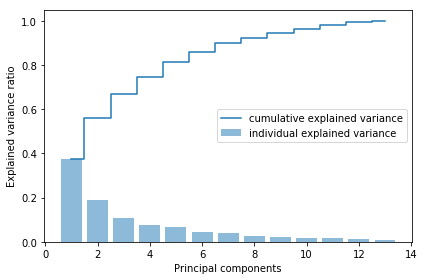

In [7]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/pca1.png', dpi=300)
plt.show()

一つ目の主成分だけで, 分散の40%近くを占めていることがわかる.
二つ目の主成分を合わせると, 分散の60%近くになる.

### 特徴変換

Wineデータセットを新しい主成分軸に変換する.
固有値の大きいものから順に固有対を並び替え, 選択された固有ベクトルから射影行列を生成する.
生成された射影行列で低次元の部分空間に変換する.

まず, 並び替えを行う.

In [8]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

次に, 最も大きい二つの固有値に対する二つの固有ベクトルを集める.
上で見た通り, これによりこのデータセットにおける分散の約60%を説明できる.

ここでは二つの固有ベクトルをとってきたが, 実際には計算効率と分類器の性能のバランスを見ながら, 主成分の個数を決定する必要がある.

In [9]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


射影行列 $W$ が得られた.
これを用いて, サンプル $x$ をPCAの部分空間に射影し, 2次元のサンプルベクトル $x'$ を得る:
$$
    x' = x W.
$$
これを全サンプルについて行うには, 次のようにすればよい:
$$
    X' = X W.
$$

変換後のWineトレーニングセットを, 2次元の散布図としてプロットしてみる.

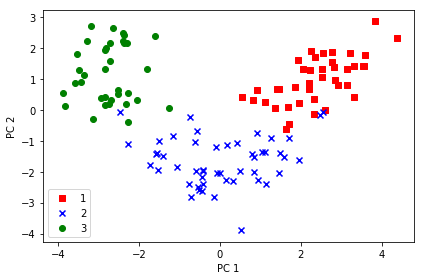

In [10]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()

分散説明率の通り, 第二座標軸の方向よりも第一座標軸の方向にデータが広がっている.

また, これらのクラスを線形分類器でうまく分割できそうなこともわかる.

上の図ではクラスラベルを表記しているが, PCAは **教師なしの** データ圧縮方法であることに注意.

ていうかscikit-learnでやればいいじゃん:

In [11]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

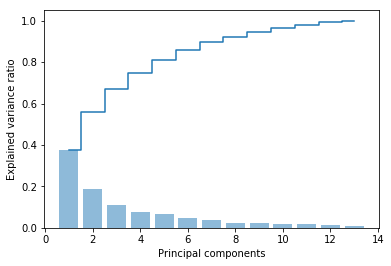

In [12]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

分散説明率はこのようになっているらしい.
なるほどなぁ.

主成分数 2 でやってみる.

In [13]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

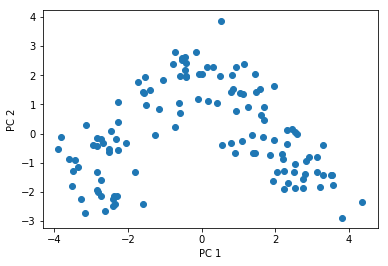

In [14]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

プロットしたら, こんな感じの分布になった.
ロジスティック回帰で分類し, 決定境界をプロットしてみる.

In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

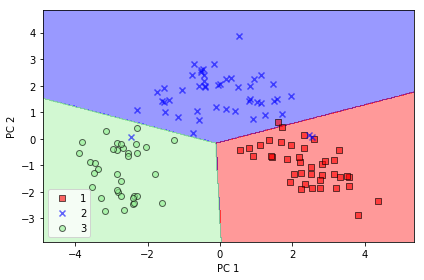

In [17]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca3.png', dpi=300)
plt.show()

トレーニングデータセットではいい感じ.

なお, 先ほどの図と異なっているのは, 固有ベクトルの方向が逆になっているだけなので, 特別問題ない.

テストデータセットではどうか?

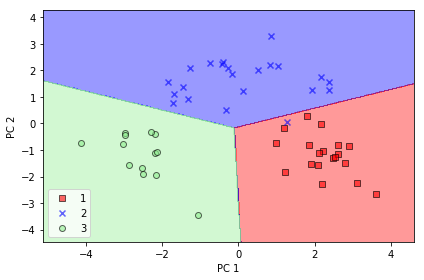

In [18]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca4.png', dpi=300)
plt.show()

いい感じ.

## 線形判別分析による教師ありデータ圧縮

- **線形判別分析** (Linear Discriminant Analysis: LDA)
    - 計算効率を高め, 正則化されていないモデルで「次元の呪い」による過学習を抑制するために使用できる.
    - クラスの分離を最適化する特徴部分空間を見つけ出そうとする線形変換法.
    - データセットの次元を減らせる.
    - 教師ありアルゴリズム.
        - 分類タスクの特徴抽出の手段としては, LDAのほうがPCAより優れている.
    - 前提:
        - データが正規分布に従っている.
        - クラスの共分散行列が同じ.
        - 特徴量が統計的にみて互いに独立している.
    - ただし, 以上の前提を多少満たしていなくても, 次元削減の手段としてのLDAはそれなりにうまくいく.
    - LDAの挙動:
        1. $d$ 次元のデータセットを標準化.
        2. クラスごとに $d$ 次元の平均ベクトルを計算.
        3. クラス間変動行列 $S_B$ と, クラス内変動行列 $S_W$ を生成.
        4. 行列 $S_W^{-1}S_B$ の固有ベクトルと対応する固有値を計算.
        5. 変換行列 $W \in M_{d,k}(\mathbb{R})$ を生成するために, 最も大きい $k$ 個の固有値に対応する $k$ 個の固有ベクトルを選択. 固有ベクトルはこの行列 $W$ の列である.
        6. 変換行列 $W$ を使ってサンプルを新しい特徴部分空間へ射影.

### 変動行列の計算

- 属するサンプル数が $N_i$ のクラス $i$ (サンプルの集合: $D_i$) 内でサンプルの平均ベクトル $m_i$ を計算する:
    $$
        m_i \triangleq  \frac{1}{N_i} \sum_{x \in D_i} x.
    $$
    - 今回は3クラスあるので, 三つの平均ベクトル $m_i, ~~ i \in \{ 1,2,3 \}$ が得られる.

In [19]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



- **クラス内変動行列** (within-class scatter matrix) $S_W$: 各クラス内で, サンプルがどの程度ばらついているかを表現するもの.
    - 個々のクラス $i$ について,
        $$
            S_i \triangleq \sum_{x \in D_i} (x-m_i)(x-m_i)^{\top}
        $$
        と定義する.
    - クラス内変動行列 $S_W$ の定義は次の通り:
        $$
            S_W \triangleq \sum_{i=1}^{c} S_i.
        $$
    - 変動行列を計算するときは, トレーニングデータセットにおいてクラスラベルが一様に分布していることが前提になる. (← なぜか?)
        - 個々の変動行列 $S_i$ を合計して $S_W$ を生成する前に, スケーリングが必要:
            $$
                \Sigma_i \triangleq \frac{1}{N_i} S_W = \frac{1}{N_i} \sum_{x \in D_i} (x-m_i)(x-m_i)^{\top}
            $$
            - スケーリングてできる $\Sigma_i$ はクラス $i$ に対する共分散行列である.

In [20]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [21]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


上記のようにクラスラベルが一様に分布していないので, スケーリングされたクラス内変動行列 (i.e., 共分散行列) を計算する.

In [22]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


- **クラス間変動行列** (between-class scatter matrix) $S_B$: 
    - $m$ をすべてのクラスのサンプルを対象として計算される全体平均とすると, クラス間変動行列 $S_B$ は次のように定義される:
        $$
            S_B \triangleq \sum_{i=1}^{c} N_i (m_i - m)(m_i - m)^{\top}.
        $$
    - ランクが1以下の $c$ 個の行列を合計したものになっている.
        - このため, $c$ 個のクラスラベルが存在する場合は, LDAでの線形判別の個数は最大で $c-1$ 個.

In [23]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


### 新しい特徴部分空間の線形判別の選択

行列 $S_W^{-1} S_B$ の固有値問題を解く.

In [24]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

固有対を計算した後は, 固有値を大きいものから降順にソートする.

In [25]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

452.721581245
156.43636122
1.05646703435e-13
3.99641853702e-14
3.40923565291e-14
2.84217094304e-14
1.4793035293e-14
1.4793035293e-14
1.3494134504e-14
1.3494134504e-14
6.49105985585e-15
6.49105985585e-15
2.65581215704e-15


3～13番目の固有値は, ほとんど0である.

共線性 (collinearity) が完全, i.e., 整列後のサンプル点がすべて直線状にある珍しいケースでは, 共分散行列のランクが1になり, 非零固有値をもつ固有ベクトルは一つだけになる.

線形判別 (固有ベクトル) によってクラスの判別情報がどの程度捕捉されるかをみるため, 固有値を減らしながら線形判別をプロットする.
ここでは, クラスの判別情報を「判別性」 (discriminability) と呼ぶことにする.

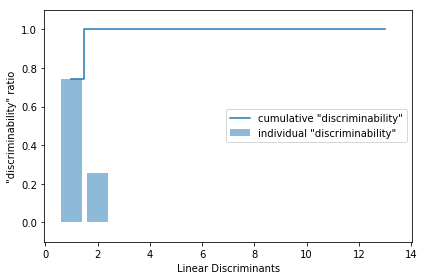

In [26]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/lda1.png', dpi=300)
plt.show()

最初の二つの線形判別はWineトレーニングデータセット内の有益な情報をほぼ100%捕捉している.

最も判別力のある二つの固有ベクトルを列方向に並べて, 変換行列 $W$ を作ってみる.

In [27]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


$W$ に行列 $X$ をかけて, トレーニングデータセットを変換し, $X'$ を得る:
$$
    X' = XW.
$$

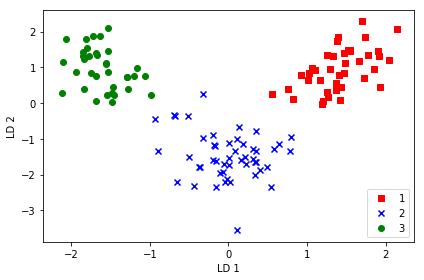

In [28]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0] * (-1),
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./figures/lda2.png', dpi=300)
plt.show()

いい感じに線形分離可能になっている.

でもやっぱscikit-learn使えばいいじゃん:

In [29]:
if Version(sklearn_version) < '0.18':
    from sklearn.lda import LDA
else:
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

ロジスティック回帰の分類器が, LDAによって変換された低次元のトレーニングデータをどのように処理するかを見てみる.

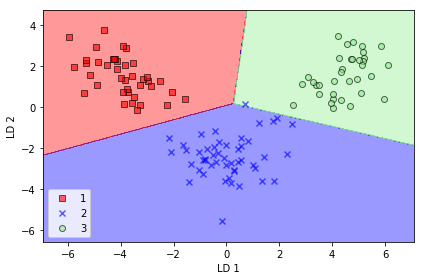

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda3.png', dpi=300)
plt.show()

一つだけミスっているが, 正則化の強さを下げれば決定境界をずらせるので, トレーニングデータセットのサンプルを完璧に分類できるようになりそう.
テストデータセットではどうか?

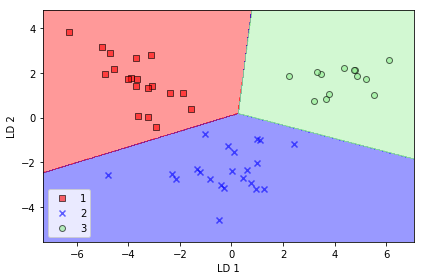

In [31]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda4.png', dpi=300)
plt.show()

完璧じゃん.

## カーネル主成分分析を使った非線形写像

ノイズを除けば線形分離可能な問題を扱ってきた.
本質的に線形分離不可能な非線形問題において, 次元削減を行うにはどうすればよいか?<br />
→ データを変換し, 線形分類器に適した新しい低次元部分空間に射影する.

カーネルPCAでやってみる.

### カーネル関数とカーネルトリック

非線形問題を解くために, サンプル $x \in \mathbb{R}^d$ を次元がより高い $k$ 次元の新しい特徴空間 $\mathbb{R}^k$ へ非線形写像
$$
    \phi: \mathbb{R}^d \to \mathbb{R}^k ~~ (k \gg d).
$$
で写像し, $\phi(x) \in \mathbb{R}^d$ を得る.

- $\phi$ は, 元の特徴量の非線形的な組み合わせを作成する.

新しい特徴空間 $\mathbb{R}^k$ で標準のPCAを行い, より低次元の空間へデータを射影し, サンプルを線形分離できるようにする.

- **カーネルトリック**: 高次元空間に写像することなく, 元の特徴空間において二つの高次元の特徴ベクトルの類似度を計算することで, 計算コストをおさえる.

標準化されたサンプル $x^{(i)} \in \mathbb{R}^d ~ (i = 1, \dots, n)$ について, 共分散行列 $\tilde{\Sigma}$ は次の通りであった:
$$
    \tilde{\Sigma} = \frac{1}{n} \sum_{i=1}^{n} x^{(i)}(x^{(i)})^{\top}.
$$
よって, このサンプルを新しい特徴空間 $\mathbb{R}^k$ へ写像してできるサンプルたちの共分散行列は
$$
    \Sigma = \frac{1}{n} \sum_{i=1}^{n} x^{(i)}(x^{(i)})^{\top}  \in M_{k}(\mathbb{R}).
$$
と書ける.

$$
    X \triangleq \begin{pmatrix} (x^{(1)})^{\top} \\ \vdots \\ (x^{(n)})^{\top} \end{pmatrix} \in M_{n, d}(\mathbb{R})
$$
に対して, 
$$
    \phi(X) \triangleq \begin{pmatrix} \phi(x^{(1)})^{\top} \\ \vdots \\ \phi(x^{(n)})^{\top} \end{pmatrix} \in M_{n, k}(\mathbb{R})
$$
とする.
$\phi(X)$ を用いると, $\Sigma$ は
$$
   \Sigma = \frac{1}{n} \phi(X)^{\top} \phi(X)
$$
と書ける.

$\Sigma$ から固有ベクトル(主成分) $\nu \in \mathbb{R}^k$ を取り出すためには, 次の固有方程式を解く:
$$
    \Sigma \nu = \lambda \nu.
$$
これは, 
$$
    \frac{1}{n} \phi(X)^{\top} \phi(X) \nu = \lambda \nu
$$
であるから, 
$$
    \nu = \frac{1}{n\lambda} \phi(X)^{\top} \phi(X) \nu
$$
と書ける.
ここで, 
$$
    a \triangleq \phi(X) \nu
$$
とおけば, 
$$
    \nu = \frac{1}{n\lambda} \phi(X)^{\top} a.
$$
両辺左から $\phi(X)$ をかけて, 
$$
    a = \frac{1}{n\lambda} \phi(X) \phi(X)^{\top} a,
$$
i.e., 
$$
    \frac{1}{n} \phi(X) \phi(X)^{\top} a = \lambda a.
$$
ここで,
$$
    K \triangleq \phi(X) \phi(X)^{\top}
$$
とおけば, 
$$
    \frac{1}{n} K a = \lambda a,
$$
i.e., $a$ は $K$ の固有ベクトルである.

このようにして定めた $K$ を**カーネル行列** (kernel matrix) といい, ベクトル間の内積, i.e., 類似度を表すものである.
カーネルトリックを利用することで, サンプル $x$ の関数 $\phi$ 同士の内積の計算をカーネル関数
$$
    k(x^{(i)}, x^{(j)}) = \phi(x^{(i)})^{\top} \phi(x^{(j)})
$$
で回避する(i.e., $K = (k(x^{(i)}, x^{(j)}))_{i,j}$ とする).

よく利用されるカーネル:

- 多項式カーネル: $k(x^{(i)}, x^{(j)}) = \left( (x^{(i)})^{\top} x^{(j)} + \theta \right)^p$.
- 双曲線正接カーネル: $k(x^{(i)}, x^{(j)}) = \tanh \left(  \right)$.
- Gaussカーネル: $k(x^{(i)}, x^{(j)}) = \exp \left( - \gamma \| x^{(i)} - x^{(j)} \|^2 \right)$

以上をまとめると, 次の通り:

1. カーネル行列 $K$ の計算.
    $$
        K = \begin{pmatrix}
        k(x^{(1)}, x^{(1)}) & \cdots & k(x^{(1)}, x^{(n)}) \\
        \vdots & \ddots & \vdots \\
        k(x^{(n)}, x^{(1)}) & \cdots & k(x^{(n)}, x^{(n)})
        \end{pmatrix}.
    $$
2. カーネル行列 $K$ の中心化:
    $$
        \boldsymbol{1}_n \triangleq \frac{1}{n}
        \begin{pmatrix}
        1 & \cdots & 1 \\
        \vdots & \ddots & \vdots \\
        1 & \cdots & 1
        \end{pmatrix}
    $$
    として, 
    $$
        K := K - \boldsymbol{1}_n K - K \boldsymbol{1}_n + \boldsymbol{1}_n K \boldsymbol{1}_n
    $$
    とする.
    - 中心化するのは, カーネルトリックでは新しい特徴空間を明示的に計算していないため, 新しい特徴空間でも中心が0であることを保証できないから.
3. 対応する固有値に基づき, 中心化されたカーネル行列 $K$ の $\ell$ 個の固有ベクトルを集める.
    - 固有値は大きい順にランク付けされている.
    - 固有ベクトル $a$ は主成分軸 $\nu$ でなく, それらの軸に射影されるサンプル $\phi(X)^{\top} \nu$ である.

### カーネルPCAの実装

実装してみる.

In [32]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from numpy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.linalg.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)

    # Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))

    return X_pc

パラメータ $\gamma$ は, 適切な値を見つける必要がある.
グリッドサーチなどを使う.

非線形サンプルデータの分離をしてみる.

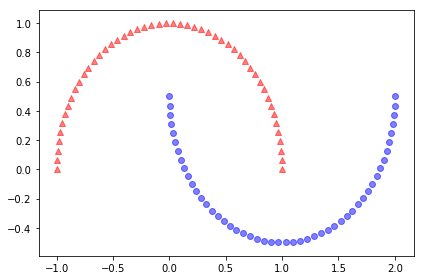

In [33]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('./figures/half_moon_1.png', dpi=300)
plt.show()

こんなやつ.

どう見ても線形分離不可能だけど, 一応PCAをかけてみる.

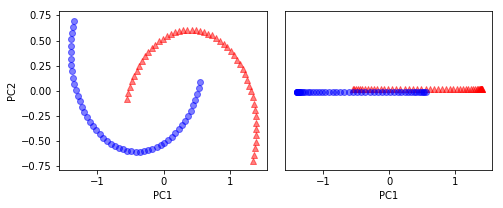

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('./figures/half_moon_2.png', dpi=300)
plt.show()

無事死亡.

カーネルPCAを試してみる.

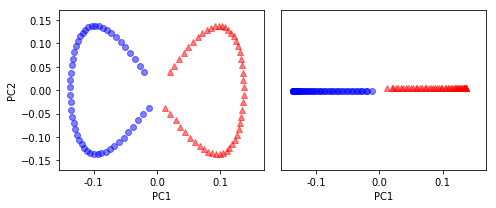

In [35]:
from matplotlib.ticker import FormatStrFormatter

X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

plt.tight_layout()
# plt.savefig('./figures/half_moon_3.png', dpi=300)
plt.show()

線形分離できそうでいい感じ.

別の例でもやってみる.

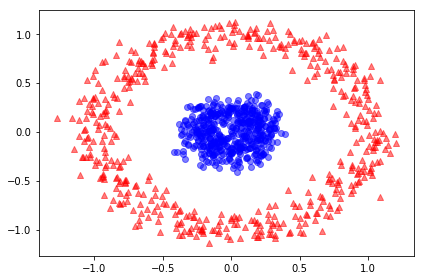

In [36]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('./figures/circles_1.png', dpi=300)
plt.show()

こんなの.

Q. ただのPCAではやっぱり無事死亡するのか?

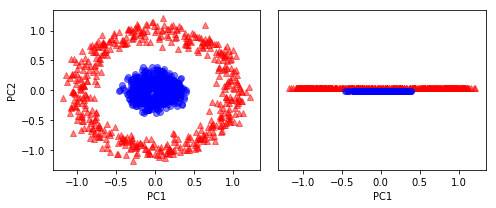

In [37]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('./figures/circles_2.png', dpi=300)
plt.show()

A. する (それはそう).

では, カーネルPCAでやってみる.

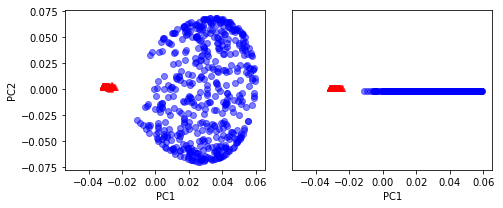

In [38]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('./figures/circles_3.png', dpi=300)
plt.show()

大変よろしい.

### 新しいデータ点を射影する

変換したいデータセットが一つのみの場合は, 上のようにすればよかった.
実際の応用では, トレーニングデータセットとテストデータセットのように, 変換したいデータセットが二つ以上存在するかもしれない.<br />
→ トレーニングデータセットに含まれていなかったデータ点を射影したい.

- 普通のPCA: 変換行列と入力サンプル間の内積が, 射影したサンプルを与える.
    - 射影行列の列ベクトルは共分散行列の $k$ 個の固有ベクトルであった.
- カーネルPCA: 新しいサンプル $x'$ について, $\phi(x')$ と共分散行列の固有ベクトル $\nu$ の内積 $\phi(x')^{\top} \nu$ が $\nu$ 主成分軸に射影したサンプルを与える.
    - カーネルトリックを用いれば, $\phi(x')^{\top} \nu$ を明示的に計算しなくて済む.
        - ただし, 新しいサンプルを射影するたびに, 元のトレーニングデータセットを再利用して, 新しいサンプル $x'$ とトレーニングデータセット内のサンプル $x$ との類似度 (i.e., カーネル関数) を計算しなければならない:<br />

        ベクトル $a$ は, $K = \phi(X)\phi(X)^{\top}$ の固有値とする, i.e., $Ka = \lambda a$.
        先ほどと同様に $\nu = \phi(X)^{\top} a$ とすれば, $n \Sigma \nu = \lambda \nu$ であるから, $\nu$ は主成分.
        よって, 内積 $\phi(x')^{\top} \nu$ は
        $$
            \phi(x')^{\top} \nu = \phi(x')^{\top} \phi(X)^{\top} a.
        $$
        ここで, 
        $$
            k(x') \triangleq \begin{pmatrix} k(x', x^{(1)}) \\ \vdots \\ k(x', x^{(n)}) \end{pmatrix} = \begin{pmatrix} \phi(x')^{\top}\phi(x^{(1)}) \\ \vdots \\ \phi(x')^{\top}\phi(x^{(n)}) \end{pmatrix}
        $$
        とおけば, 
        $$
            \phi(x')^{\top} \nu = k(x')^{\top} a.
        $$

新しいサンプルとトレーニングデータセット内のサンプルとの間で類似度を計算した後は, 固有ベクトル $a$ をその固有値 $\lambda$ で正規化する必要がある. (←なぜか?)

先ほどの関数を書き換えて, カーネル行列の固有値を返すようにする.

In [39]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   
     
     lambdas: list
       Eigenvalues

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)

    # Collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:, -i]
                              for i in range(1, n_components + 1)))

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[-i] for i in range(1, n_components + 1)]

    return alphas, lambdas

新しい半月型データセットを用意し, GaussカーネルPCAで1次元の部分空間に射影する.

In [40]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

新しいデータ点を以下のように仮定:

In [41]:
x_new = X[-1]
x_new

array([ 0.4816, -0.3551])

もとの射影は次の通り:

In [42]:
x_proj = alphas[-1] # original projection
x_proj

array([ 0.1192])

新しい点とみて射影すると次のようになる.

In [43]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the "new" datapoint
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([ 0.1192])

一致している.
図示してみる.

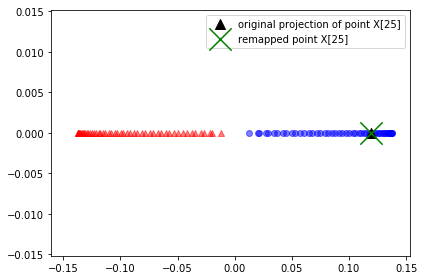

In [44]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='remapped point X[25]', marker='x', s=500)
plt.legend(scatterpoints=1)

plt.tight_layout()
# plt.savefig('./figures/reproject.png', dpi=300)
plt.show()

正しく射影できた.

ていうかscikit-learnにカーネルPCAあるじゃん.

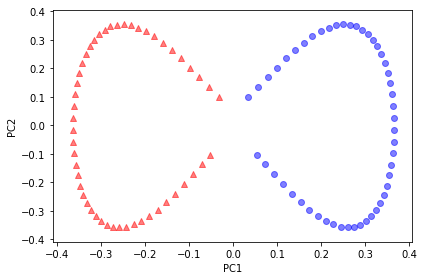

In [46]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('./figures/scikit_kpca.png', dpi=300)
plt.show()

もちろん, 結果は上で実装したものと一緒.